✅ Macro indicators head:
       SP500_growth  Nasdaq_growth  Inflation
DATE                                        
2016      0.095350       0.075031   0.012674
2017      0.194200       0.282414   0.021314
2018     -0.062373      -0.038837   0.024390
2019      0.288781       0.352256   0.018133
2020      0.162589       0.436404   0.012529
✅ Dataset finale pronto
  Company  Year Category   Revenue    EBITDA  Net_Income  Revenue_lag1  \
5    AAPL  2017       IT  229234.0   71501.0     48351.0      215639.0   
4    AAPL  2018       IT  265595.0   81801.0     59531.0      229234.0   
3    AAPL  2019       IT  260174.0   76477.0     55256.0      265595.0   
2    AAPL  2020       IT  274515.0   77344.0     57411.0      260174.0   
1    AAPL  2021       IT  365817.0  120233.0     94680.0      274515.0   

   Revenue_lag2  EBITDA_lag1  EBITDA_lag2  ...  logRev_lag2  logEBITDA_lag1  \
5      233715.0      70529.0      82487.0  ...    12.361862       11.163793   
4      215639.0      71501.0    

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 11
  warnings.warn('covariance of constraints does not have full '


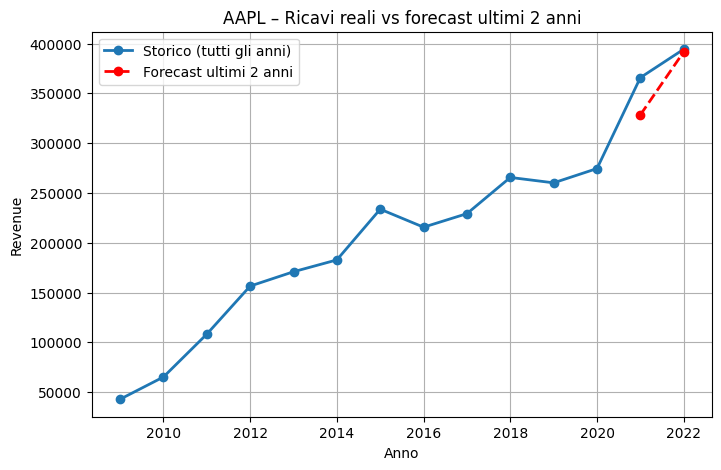

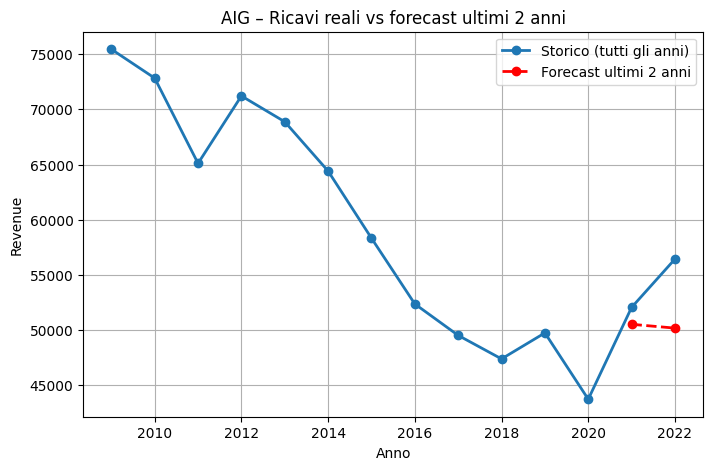

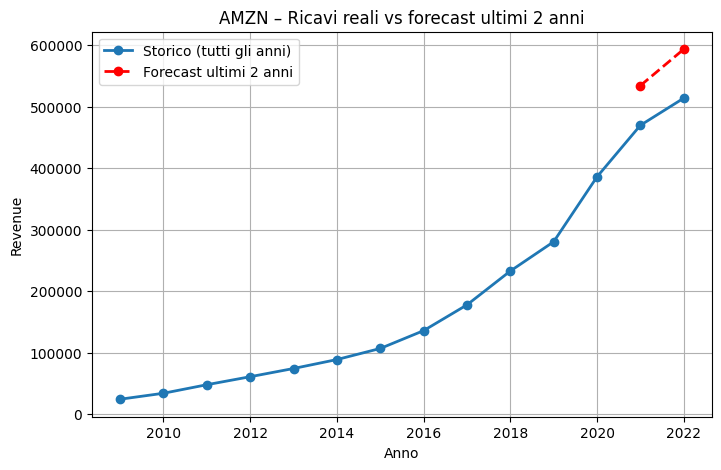

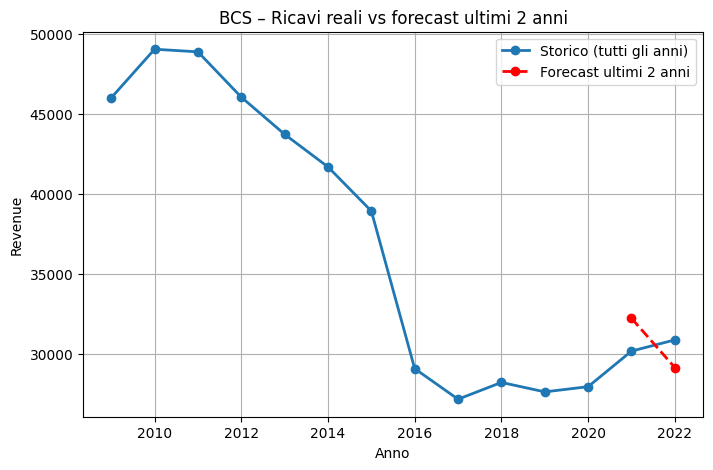

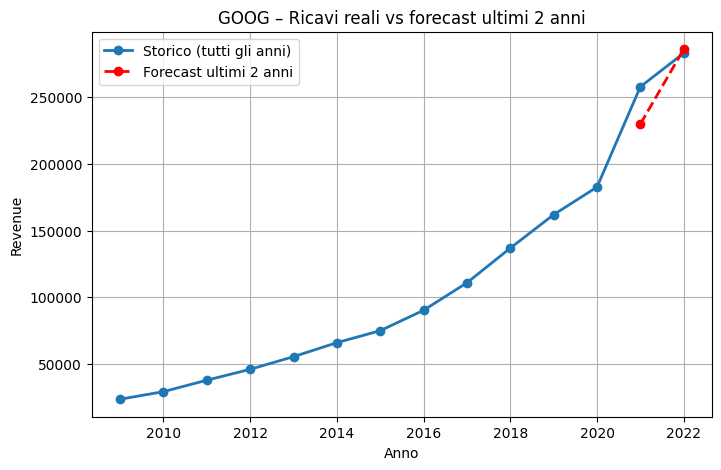

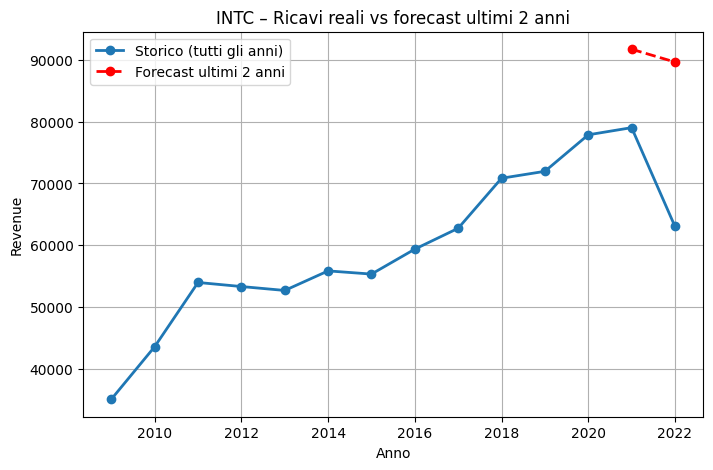

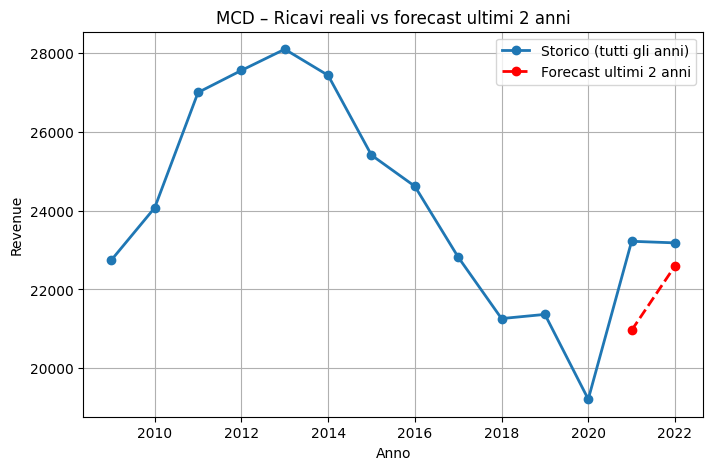

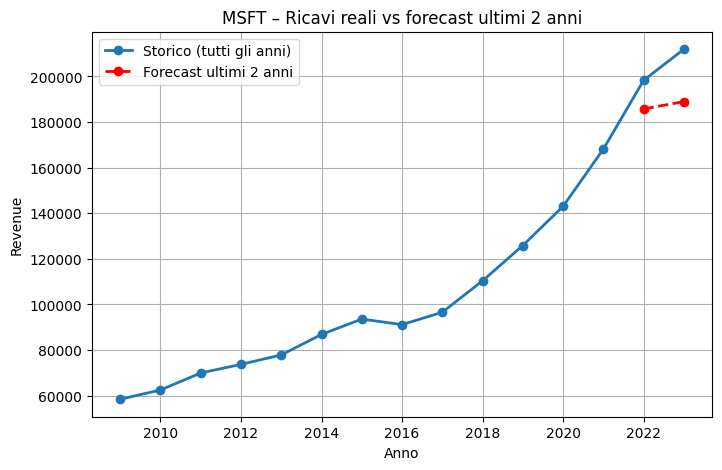

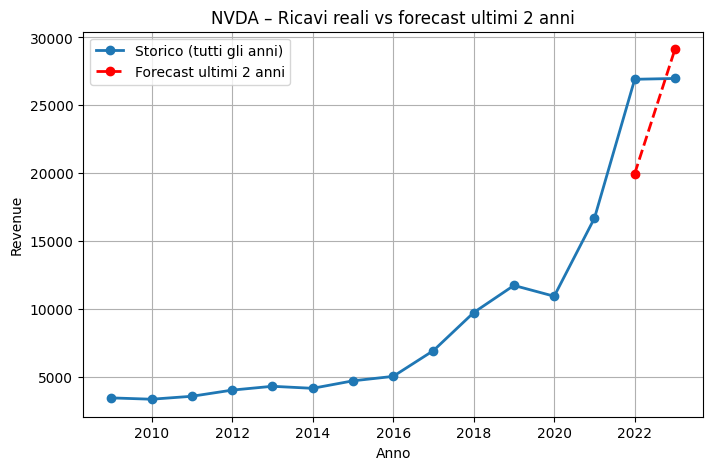

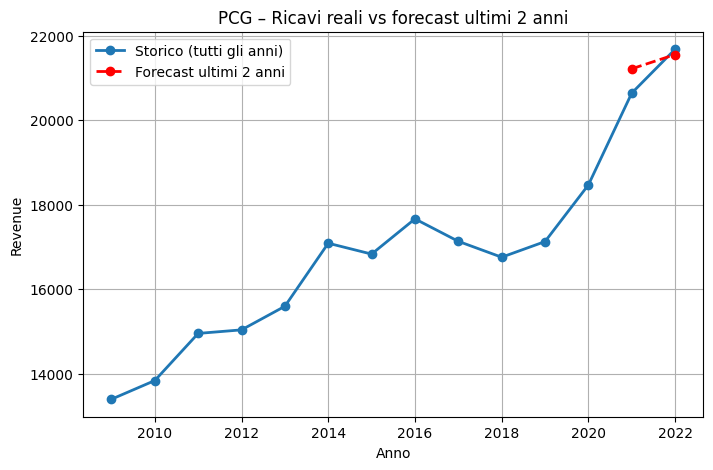

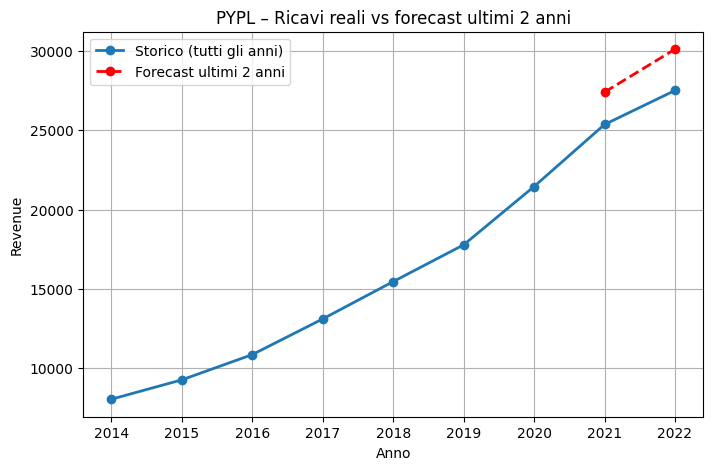


📊 Metriche per azienda:
   Company     MAE_model  MAPE_model  MAE_naive  MAPE_naive
0     AAPL  19997.357111    5.440939   59906.50   16.094328
1      AIG   3895.763408    7.017108    6350.50   11.872634
2     AMZN  72054.540027   14.609034   63959.50   13.209761
3      BCS   1888.642802    6.195335    1460.27    4.814002
4     GOOG  15421.780490    5.935346   50154.50   19.031412
5     INTC  19627.623931   29.096775    8563.50   13.395805
6      MCD   1425.147682    6.139018    2027.70    8.731618
7     MSFT  17752.032034    8.580456   21913.50   10.830789
8     NVDA   4555.493778   16.917202    5149.50   19.132917
9      PCG    350.455167    1.683156    1605.50    7.657452
10    PYPL   2323.934675    8.759106    3032.00   11.620526

📊 Medie complessive su tutte le aziende:
MAE modello   = 14481.161009692196
MAPE modello  = 10.03395214970716 %
MAE naive     = 20374.815454545456
MAPE naive    = 12.399204030955673 %


In [93]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

# --- CARICAMENTO ---
df = pd.read_csv("/Users/GeorgKhella/Desktop/Financial Statements.csv")

# --- PULIZIA NOMI COLONNE ---
df.columns = df.columns.str.strip().str.replace(" ", "_")

# --- NORMALIZZA SETTORE ---
df["Category"] = df["Category"].str.strip().str.upper()

# --- SELEZIONE VARIABILI CHIAVE ---
df_extra = df[['Company','Year','Category','Revenue','EBITDA','Net_Income']].copy()
df_extra = df_extra.sort_values(['Company','Year'])

# --- LAG BASE ---
for col in ['Revenue','EBITDA','Net_Income']:
    df_extra[f'{col}_lag1'] = df_extra.groupby('Company')[col].shift(1)
    df_extra[f'{col}_lag2'] = df_extra.groupby('Company')[col].shift(2)

# --- FEATURE ENGINEERING SOLO CON INFO FINO A t-1 ---
df_extra['Rev_growth_lag1'] = (df_extra['Revenue_lag1'] / df_extra['Revenue_lag2']) - 1
df_extra['EBITDA_margin_lag1'] = df_extra['EBITDA_lag1'] / df_extra['Revenue_lag1'].replace(0, np.nan)
df_extra['NI_margin_lag1']     = df_extra['Net_Income_lag1'] / df_extra['Revenue_lag1'].replace(0, np.nan)

# --- LOG TRASFORMAZIONI ---
df_extra['logRev']      = np.log1p(df_extra['Revenue'])
df_extra['logRev_lag1'] = np.log1p(df_extra['Revenue_lag1'])
df_extra['logRev_lag2'] = np.log1p(df_extra['Revenue_lag2'])
df_extra['logEBITDA_lag1'] = np.sign(df_extra['EBITDA_lag1']) * np.log1p(np.abs(df_extra['EBITDA_lag1']))
df_extra['logNI_lag1']     = np.sign(df_extra['Net_Income_lag1']) * np.log1p(np.abs(df_extra['Net_Income_lag1']))

# --- DATI MACRO TUTTO DA FRED ---
start = "2000-01-01"
end   = "2024-12-31"

sp500 = web.DataReader("SP500", "fred", start, end)          # S&P500 index
nasdaq = web.DataReader("NASDAQCOM", "fred", start, end)     # Nasdaq Composite
cpi = web.DataReader("CPIAUCSL", "fred", start, end)         # CPI USA

# Calcola variazioni annuali
sp500_growth = sp500.resample("YE").last().pct_change().rename(columns={"SP500":"SP500_growth"})
nasdaq_growth = nasdaq.resample("YE").last().pct_change().rename(columns={"NASDAQCOM":"Nasdaq_growth"})
cpi_growth = cpi.resample("YE").mean().pct_change().rename(columns={"CPIAUCSL":"Inflation"})

# Merge macro
macro = pd.concat([sp500_growth, nasdaq_growth, cpi_growth], axis=1).dropna()
macro.index = macro.index.year
print("✅ Macro indicators head:\n", macro.head())

# --- MERGE MACRO CON BILANCI ---
df_extra = df_extra.merge(macro, left_on="Year", right_index=True, how="left")

# Lag per variabili macro (solo info fino a t-1)
for col in ["SP500_growth","Nasdaq_growth","Inflation"]:
    df_extra[f"{col}_lag1"] = df_extra.groupby("Company")[col].shift(1)
# Dummy di anno laggato (effetto dell'anno precedente)
df_extra["Year_lag1"] = df_extra.groupby("Company")["Year"].shift(1)


# --- PULIZIA RIGHE INUTILIZZABILI (lag mancanti o inf) ---
df_extra.replace([np.inf, -np.inf], np.nan, inplace=True)
df_extra = df_extra.dropna(subset=[
    'logRev','logRev_lag1','logRev_lag2',
    'Rev_growth_lag1','EBITDA_margin_lag1','NI_margin_lag1',
    'logEBITDA_lag1','logNI_lag1',
    "SP500_growth_lag1","Nasdaq_growth_lag1","Inflation_lag1"
])

print("✅ Dataset finale pronto")
print(df_extra.head())

# --- CALCOLO VIF ---
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_extra[['logRev_lag1','logRev_lag2',
              'Rev_growth_lag1','EBITDA_margin_lag1','NI_margin_lag1',
              'logEBITDA_lag1','logNI_lag1',
              'SP500_growth_lag1','Nasdaq_growth_lag1','Inflation_lag1']]

X = add_constant(X)
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n📊 VIF per le variabili:")
print(vif)

# --- MODELLO CON MACRO + FE azienda (ridotto per ridurre multicollinearità) ---
formula_forecast = (
    "logRev ~ logRev_lag1 "
    "+ EBITDA_margin_lag1 + NI_margin_lag1 "
    "+ logEBITDA_lag1 + logNI_lag1 "
    "+ SP500_growth_lag1 + Nasdaq_growth_lag1 + Inflation_lag1 "
    "+ C(Category) + C(Year_lag1)"
)

model_all = smf.ols(formula=formula_forecast, data=df_extra)\
               .fit(cov_type="cluster", cov_kwds={"groups": df_extra["Company"]})
print(model_all.summary())

# --- FUNZIONE FORECAST (ultimi 2 anni out) ---
# dataset grezzo solo per i plot
df_raw = df[['Company','Year','Revenue']].copy()

def panel_forecast(company, df_extra, df_raw, use_year_fe=True):
    group_raw = df_raw[df_raw["Company"] == company]  # tutti gli anni reali
    group = df_extra[df_extra["Company"] == company]  # anni usabili dal modello
    cutoff = group["Year"].max() - 2

    # train/test
    df_train = df_extra[~((df_extra["Company"] == company) & (df_extra["Year"] > cutoff))].copy()
    df_test  = df_extra[(df_extra["Company"] == company) & (df_extra["Year"] > cutoff)].copy()

    # categorie
    df_train["Company"] = pd.Categorical(df_train["Company"], categories=sorted(df_extra["Company"].unique()))
    df_test["Company"]  = pd.Categorical(df_test["Company"],  categories=sorted(df_extra["Company"].unique()))
    if use_year_fe:
        years_all = sorted(df_extra["Year"].unique())
        df_train["Year"] = pd.Categorical(df_train["Year"], categories=years_all)
        df_test["Year"]  = pd.Categorical(df_test["Year"],  categories=years_all)

    # stima
    formula = formula_forecast if not use_year_fe else (formula_forecast + " + C(Year)")
    model = smf.ols(formula=formula, data=df_train)\
               .fit(cov_type="cluster", cov_kwds={"groups": df_train["Company"]})

    preds_log = model.predict(df_test)
    preds_rev = np.expm1(preds_log)

    # --- plot ---
    plt.figure(figsize=(8,5))
    plt.plot(group_raw["Year"], group_raw["Revenue"], marker="o", linewidth=2, label="Storico (tutti gli anni)")
    plt.plot(df_test["Year"], preds_rev, marker="o", linestyle="--", linewidth=2, color="red", label="Forecast ultimi 2 anni")
    plt.title(f"{company} – Ricavi reali vs forecast ultimi 2 anni")
    plt.xlabel("Anno"); plt.ylabel("Revenue"); plt.grid(True); plt.legend()
    plt.show()

    return pd.DataFrame({
        "Year": df_test["Year"].values,
        "Reale": df_test["Revenue"].values,
        "Previsto": preds_rev
    })



# --- METRICHE ---
def mae(y_true, y_pred):  
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate_models(df_extra, df_raw, exclude=[]):
    rows = []
    for comp in df_extra["Company"].unique():
        if comp in exclude:
            continue
        g = df_extra[df_extra["Company"] == comp]
        if g["Year"].nunique() < 4:  # serve almeno spazio per lag + test
            continue

        try:
            res = panel_forecast(comp, df_extra, df_raw, use_year_fe=True)
        except Exception as e:
            print(f"❌ Problema con {comp}: {e}")
            continue

        # valori reali e previsti (solo ultimi 2 anni)
        y_true = res["Reale"].values
        y_pred = res["Previsto"].values

        # benchmark naive: Revenue_{t-1}
        y_naive = df_extra.loc[
            (df_extra["Company"] == comp) & (df_extra["Year"].isin(res["Year"])),
            "Revenue_lag1"
        ].values

        rows.append({
            "Company": comp,
            "MAE_model": mae(y_true, y_pred),
            "MAPE_model": mape(y_true, y_pred),
            "MAE_naive": mae(y_true, y_naive),
            "MAPE_naive": mape(y_true, y_naive)
        })

    results = pd.DataFrame(rows)

    # medie complessive
    avg_mae_model = results["MAE_model"].mean()
    avg_mape_model = results["MAPE_model"].mean()
    avg_mae_naive = results["MAE_naive"].mean()
    avg_mape_naive = results["MAPE_naive"].mean()

    print("\n📊 Metriche per azienda:")
    print(results)

    print("\n📊 Medie complessive su tutte le aziende:")
    print(f"MAE modello   = {avg_mae_model}")
    print(f"MAPE modello  = {avg_mape_model} %")
    print(f"MAE naive     = {avg_mae_naive}")
    print(f"MAPE naive    = {avg_mape_naive} %")

    return results
metrics = validate_models(df_extra, df_raw)


In [113]:
# --- TUNING RIDGE ---
from collections import defaultdict

def validate_models_ridge(df_extra, df_raw, alphas, exclude=[]):
    results_alpha = defaultdict(list)

    for alpha in alphas:
        rows = []
        for comp in df_extra["Company"].unique():
            if comp in exclude:
                continue
            g = df_extra[df_extra["Company"] == comp]
            if g["Year"].nunique() < 4:
                continue

            try:
                cutoff = g["Year"].max() - 2
                df_train = df_extra[~((df_extra["Company"] == comp) & (df_extra["Year"] > cutoff))].copy()
                df_test  = df_extra[(df_extra["Company"] == comp) & (df_extra["Year"] > cutoff)].copy()

                model_ridge = smf.ols(formula=formula_forecast, data=df_train)
                res_ridge = model_ridge.fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0)

                preds_log = res_ridge.predict(df_test)
                preds_rev = np.expm1(preds_log)

                y_true = df_test["Revenue"].values
                y_naive = df_test["Revenue_lag1"].values

                rows.append({
                    "Company": comp,
                    "MAE_model": mae(y_true, preds_rev),
                    "MAPE_model": mape(y_true, preds_rev),
                    "MAE_naive": mae(y_true, y_naive),
                    "MAPE_naive": mape(y_true, y_naive)
                })
            except Exception as e:
                print(f"❌ Problema con {comp}, alpha={alpha}: {e}")
                continue

        results = pd.DataFrame(rows)
        if not results.empty:
            results_alpha["alpha"].append(alpha)
            results_alpha["MAE_model"].append(results["MAE_model"].mean())
            results_alpha["MAPE_model"].append(results["MAPE_model"].mean())
            results_alpha["MAE_naive"].append(results["MAE_naive"].mean())
            results_alpha["MAPE_naive"].append(results["MAPE_naive"].mean())

    return pd.DataFrame(results_alpha)


# --- ESEGUI TUNING ---
alphas = np.arange(0.01, 0.51, 0.01)
results_ridge = validate_models_ridge(df_extra, df_raw, alphas)

print("\n📊 Confronto alpha:")
print(results_ridge)

best_alpha = results_ridge.loc[results_ridge["MAPE_model"].idxmin(), "alpha"]
print(f"\n✅ Alpha migliore = {best_alpha}")



📊 Confronto alpha:
    alpha     MAE_model  MAPE_model     MAE_naive  MAPE_naive
0    0.01  15028.936511   11.094247  20374.815455   12.399204
1    0.02  13729.012786   10.479902  20374.815455   12.399204
2    0.03  12748.817945    9.970814  20374.815455   12.399204
3    0.04  11994.456136    9.558303  20374.815455   12.399204
4    0.05  11394.033680    9.217664  20374.815455   12.399204
5    0.06  10902.977823    8.931032  20374.815455   12.399204
6    0.07  10501.923604    8.726092  20374.815455   12.399204
7    0.08  10178.954441    8.613876  20374.815455   12.399204
8    0.09   9912.031285    8.543312  20374.815455   12.399204
9    0.10   9717.969739    8.504121  20374.815455   12.399204
10   0.11   9547.135970    8.473354  20374.815455   12.399204
11   0.12   9395.361069    8.449428  20374.815455   12.399204
12   0.13   9261.108559    8.439360  20374.815455   12.399204
13   0.14   9335.803849    8.485623  20374.815455   12.399204
14   0.15   9423.692472    8.549223  20374.815455 

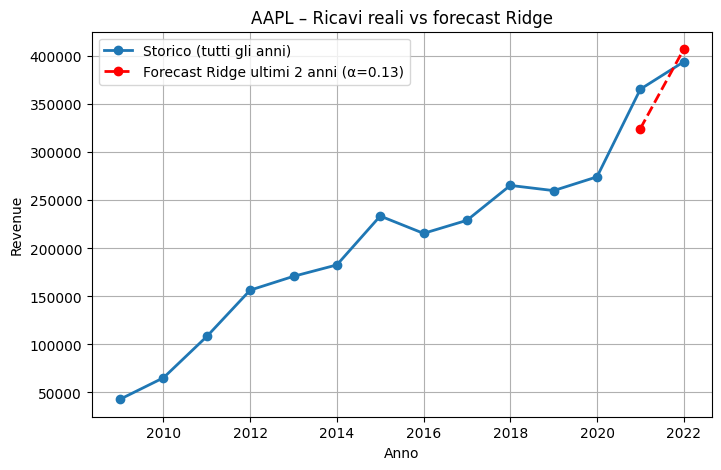

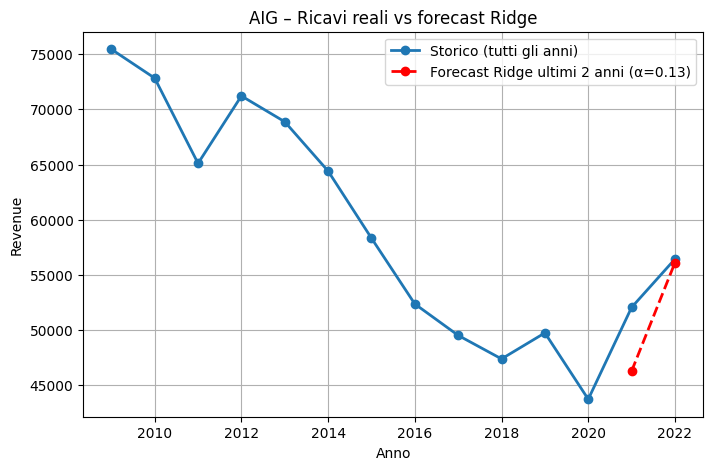

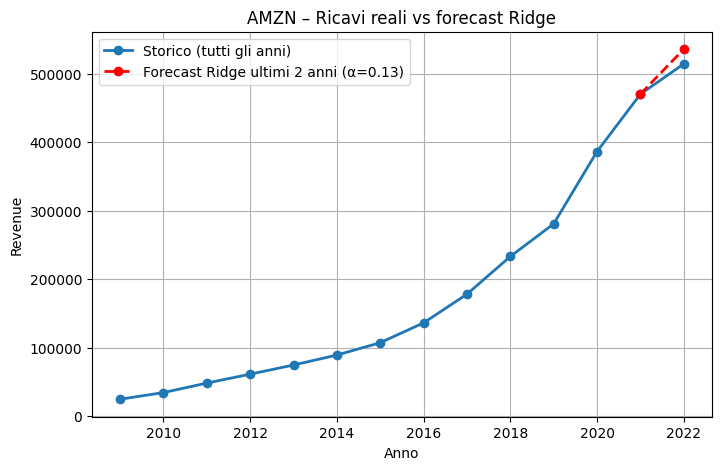

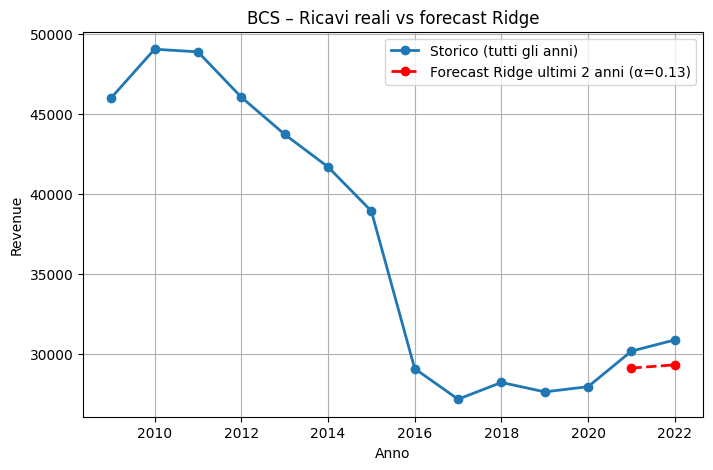

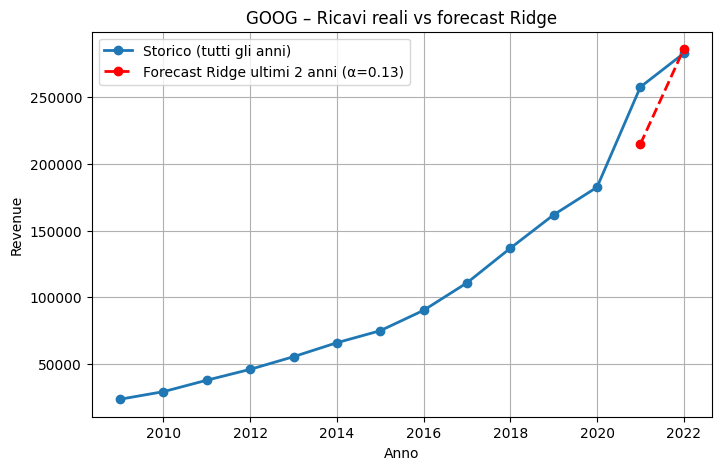

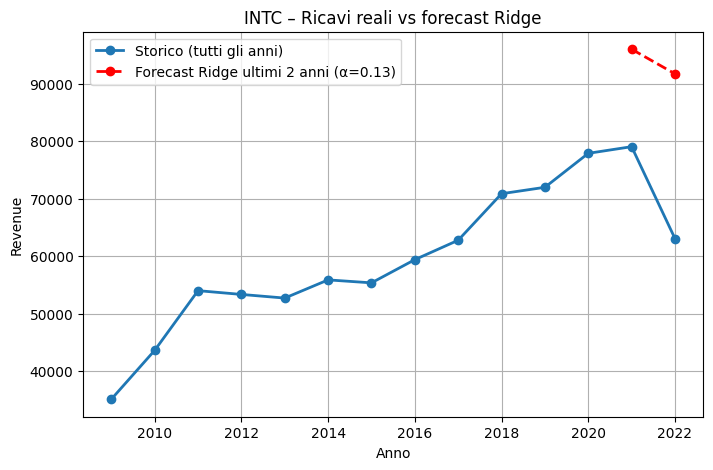

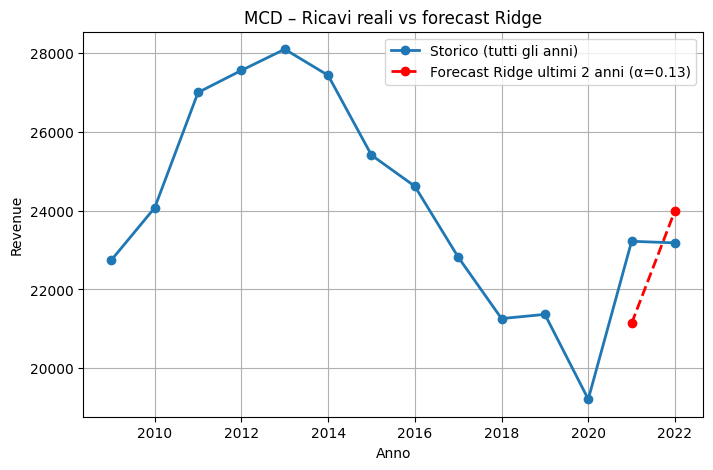

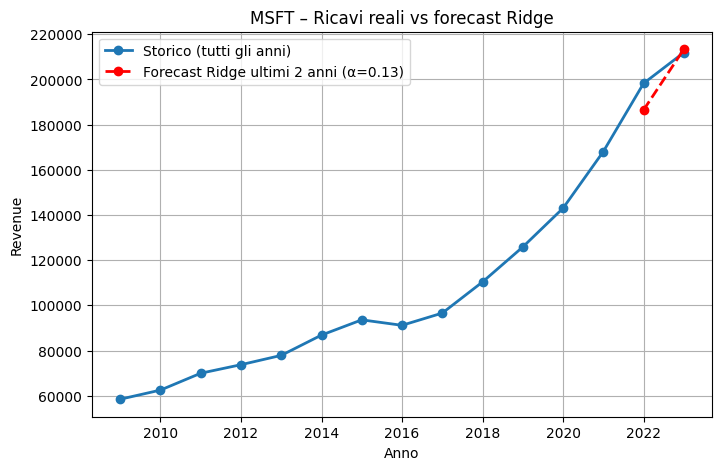

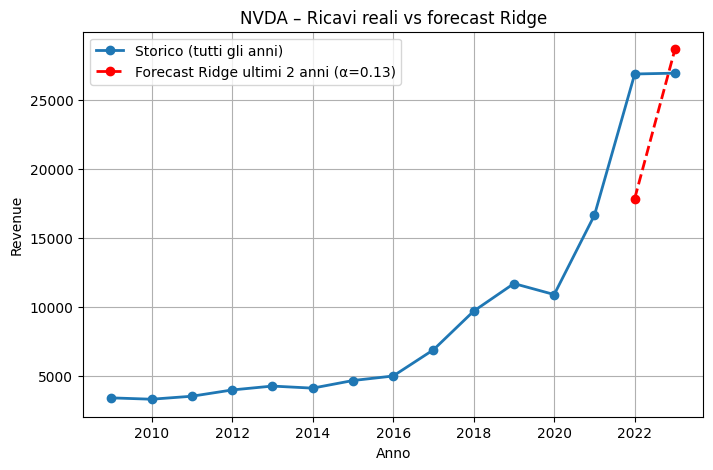

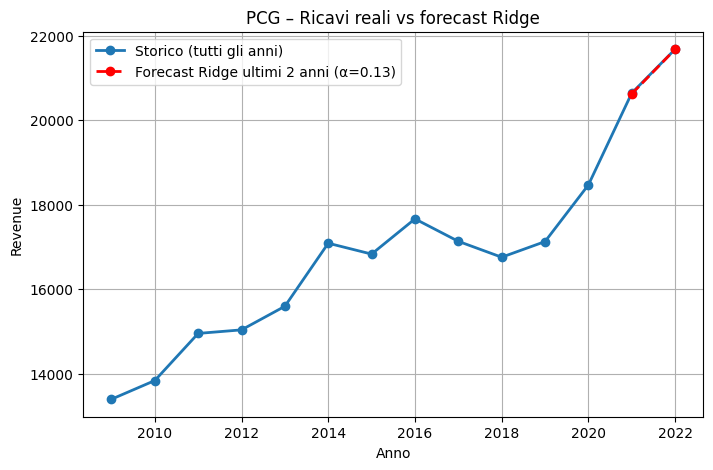

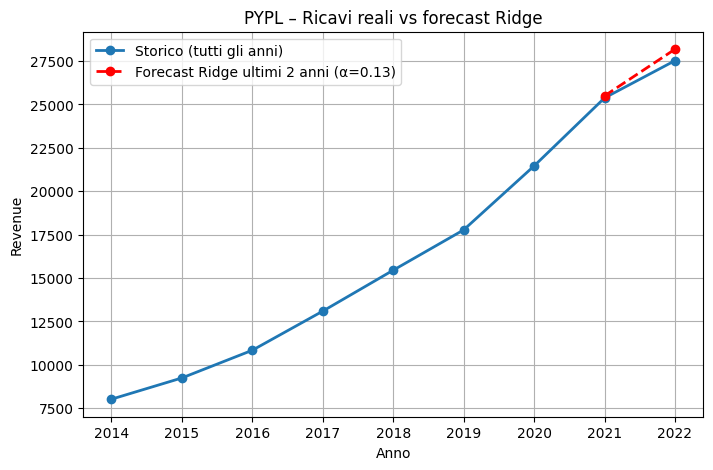


📊 Metriche Ridge (alpha = 0.13) per azienda:
   Company     MAE_model  MAPE_model  MAE_naive  MAPE_naive
0     AAPL  27061.327295    7.267924   59906.50   16.094328
1      AIG   3049.576279    5.833897    6350.50   11.872634
2     AMZN  10831.818614    2.108922   63959.50   13.209761
3      BCS   1307.966836    4.277027    1460.27    4.814002
4     GOOG  22974.957270    8.863518   50154.50   19.031412
5     INTC  22789.195863   33.427767    8563.50   13.395805
6      MCD   1452.555913    6.257908    2027.70    8.731618
7     MSFT   6621.310774    3.315666   21913.50   10.830789
8     NVDA   5383.477627   19.995343    5149.50   19.132917
9      PCG     11.040621    0.053093    1605.50    7.657452
10    PYPL    388.967057    1.431900    3032.00   11.620526

📊 Medie complessive Ridge (alpha = 0.13):
MAE modello   = 9261.108558895774
MAPE modello  = 8.439360383177041 %
MAE naive     = 20374.815454545456
MAPE naive    = 12.399204030955673 %


In [115]:
# --- VALIDAZIONE RIDGE (alpha=0.13) ---
def validate_models_ridge(df_extra, df_raw, alpha=0.13, exclude=[]):
    rows = []
    for comp in df_extra["Company"].unique():
        if comp in exclude:
            continue
        g = df_extra[df_extra["Company"] == comp]
        if g["Year"].nunique() < 4:  # serve almeno spazio per lag + test
            continue

        try:
            # train/test split sugli ultimi 2 anni
            cutoff = g["Year"].max() - 2
            df_train = df_extra[~((df_extra["Company"] == comp) & (df_extra["Year"] > cutoff))].copy()
            df_test  = df_extra[(df_extra["Company"] == comp) & (df_extra["Year"] > cutoff)].copy()
            group_raw = df_raw[df_raw["Company"] == comp]

            # modello Ridge
            model_ridge = smf.ols(formula=formula_forecast, data=df_train)
            res_ridge = model_ridge.fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0)

            preds_log = res_ridge.predict(df_test)
            preds_rev = np.expm1(preds_log)

            # --- plot ---
            plt.figure(figsize=(8,5))
            plt.plot(group_raw["Year"], group_raw["Revenue"], marker="o", linewidth=2, label="Storico (tutti gli anni)")
            plt.plot(df_test["Year"], preds_rev, marker="o", linestyle="--", linewidth=2, color="red", label=f"Forecast Ridge ultimi 2 anni (α={alpha})")
            plt.title(f"{comp} – Ricavi reali vs forecast Ridge")
            plt.xlabel("Anno"); plt.ylabel("Revenue")
            plt.grid(True); plt.legend()
            plt.show()

            # metriche
            y_true = df_test["Revenue"].values
            y_naive = df_test["Revenue_lag1"].values

            rows.append({
                "Company": comp,
                "MAE_model": mae(y_true, preds_rev),
                "MAPE_model": mape(y_true, preds_rev),
                "MAE_naive": mae(y_true, y_naive),
                "MAPE_naive": mape(y_true, y_naive)
            })
        except Exception as e:
            print(f"❌ Problema con {comp}: {e}")
            continue

    results = pd.DataFrame(rows)

    # medie complessive
    avg_mae_model = results["MAE_model"].mean()
    avg_mape_model = results["MAPE_model"].mean()
    avg_mae_naive = results["MAE_naive"].mean()
    avg_mape_naive = results["MAPE_naive"].mean()

    print("\n📊 Metriche Ridge (alpha = {:.2f}) per azienda:".format(alpha))
    print(results)

    print("\n📊 Medie complessive Ridge (alpha = {:.2f}):".format(alpha))
    print(f"MAE modello   = {avg_mae_model}")
    print(f"MAPE modello  = {avg_mape_model} %")
    print(f"MAE naive     = {avg_mae_naive}")
    print(f"MAPE naive    = {avg_mape_naive} %")

    return results

# --- ESECUZIONE ---
metrics_ridge = validate_models_ridge(df_extra, df_raw, alpha=0.13)



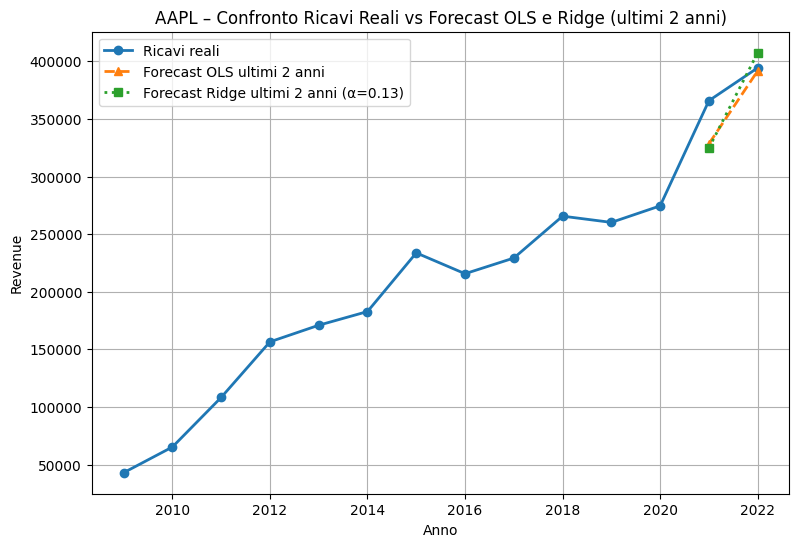

✅ Confronto completato per AAPL
   Year     Reale   Forecast_OLS  Forecast_Ridge
1  2021  365817.0  328408.034520   324806.605852
0  2022  394328.0  391742.251258   407440.260442 



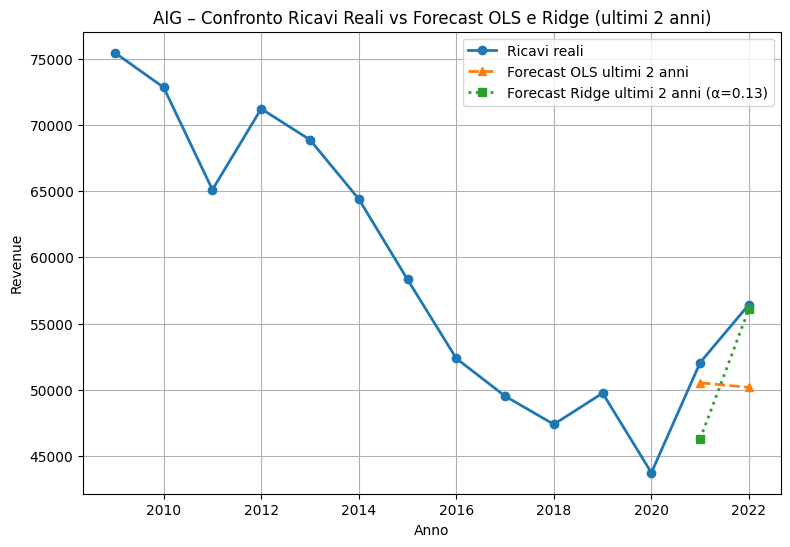

✅ Confronto completato per AIG
    Year    Reale  Forecast_OLS  Forecast_Ridge
53  2021  52057.0  50524.248824    46283.190367
52  2022  56437.0  50178.224359    56111.657075 



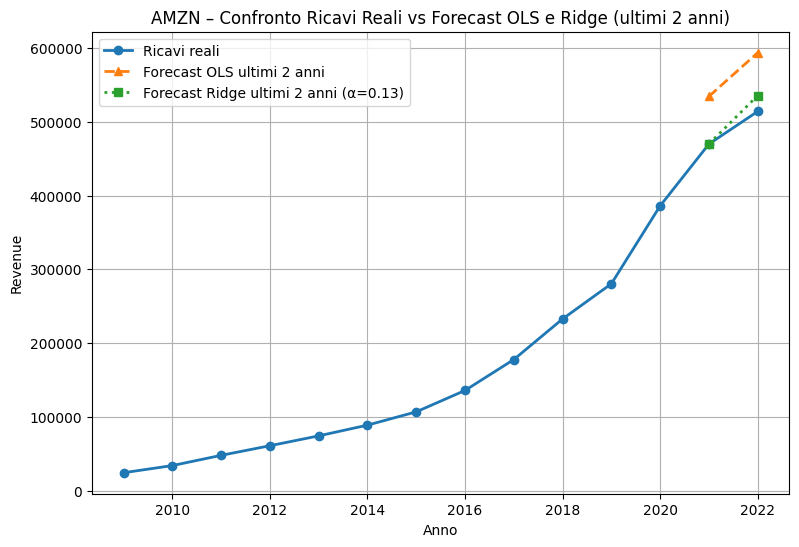

✅ Confronto completato per AMZN
     Year     Reale   Forecast_OLS  Forecast_Ridge
148  2021  469822.0  534366.031690   469985.444890
147  2022  513983.0  593548.048364   535483.192337 



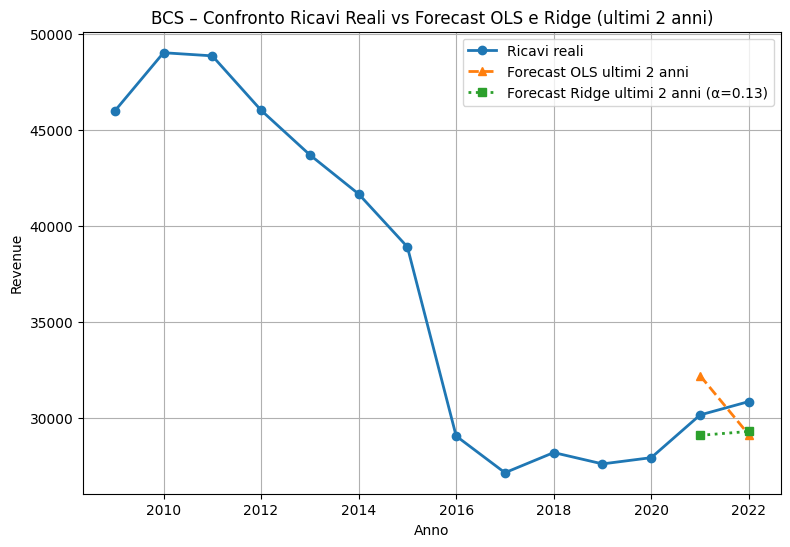

✅ Confronto completato per BCS
     Year     Reale  Forecast_OLS  Forecast_Ridge
105  2021  30169.69  32220.609168    29109.646704
104  2022  30868.08  29141.713563    29312.189624 



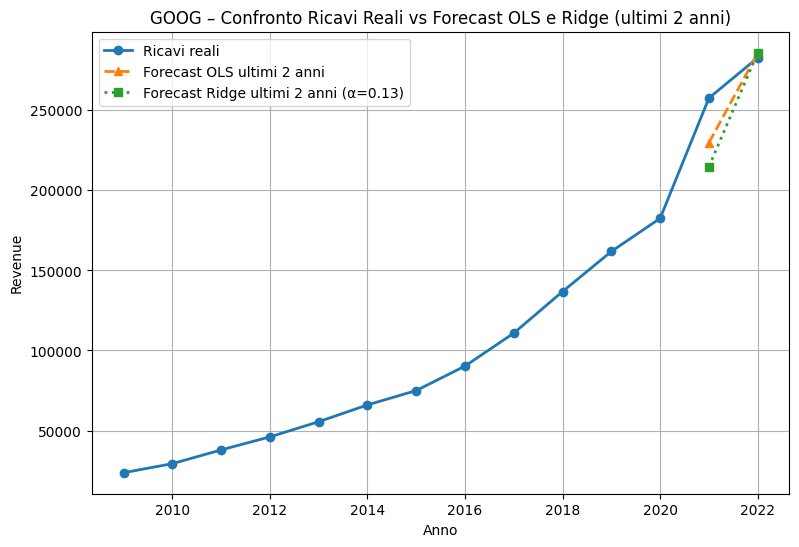

✅ Confronto completato per GOOG
    Year     Reale   Forecast_OLS  Forecast_Ridge
30  2021  257637.0  229714.709968   214813.128847
29  2022  282836.0  285757.270948   285962.043387 



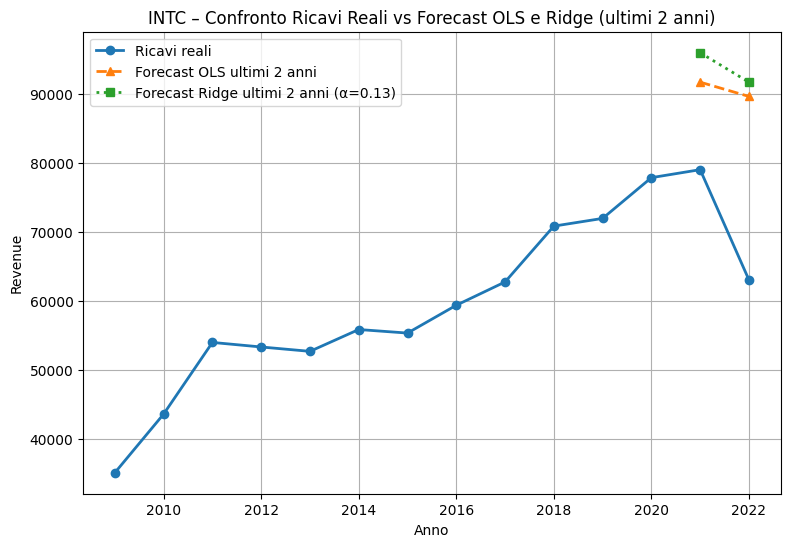

✅ Confronto completato per INTC
     Year    Reale  Forecast_OLS  Forecast_Ridge
134  2021  79024.0  91700.931128    95963.454275
133  2022  63054.0  89632.316734    91692.937451 



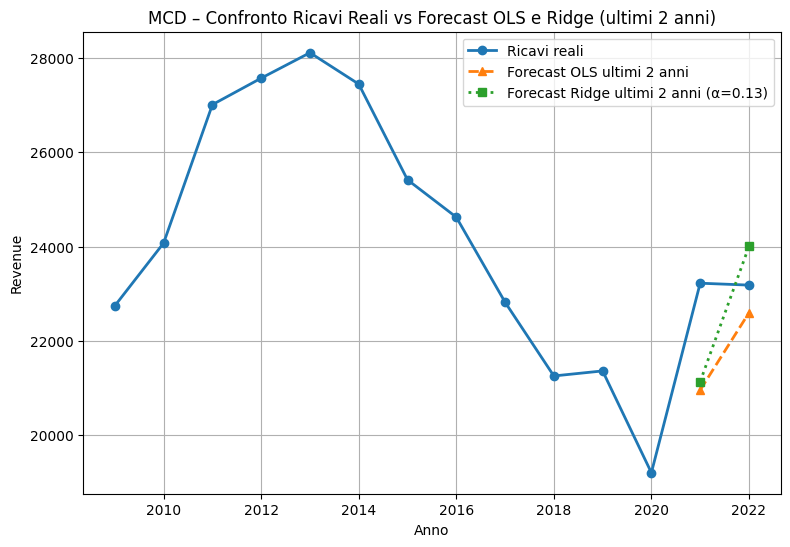

✅ Confronto completato per MCD
    Year    Reale  Forecast_OLS  Forecast_Ridge
91  2021  23222.9  20959.614959    21136.707772
90  2022  23182.6  22595.589676    24001.519598 



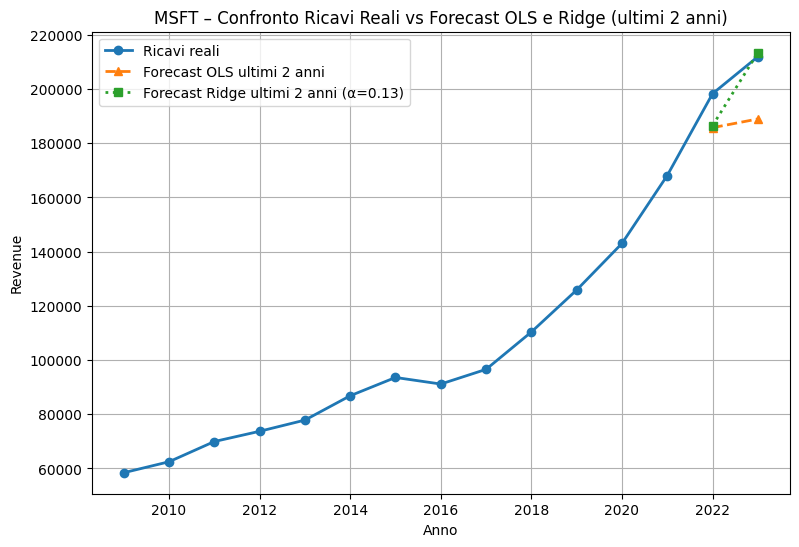

✅ Confronto completato per MSFT
    Year     Reale   Forecast_OLS  Forecast_Ridge
15  2022  198270.0  185737.590431   186497.801929
14  2023  211915.0  188943.345501   213385.423476 



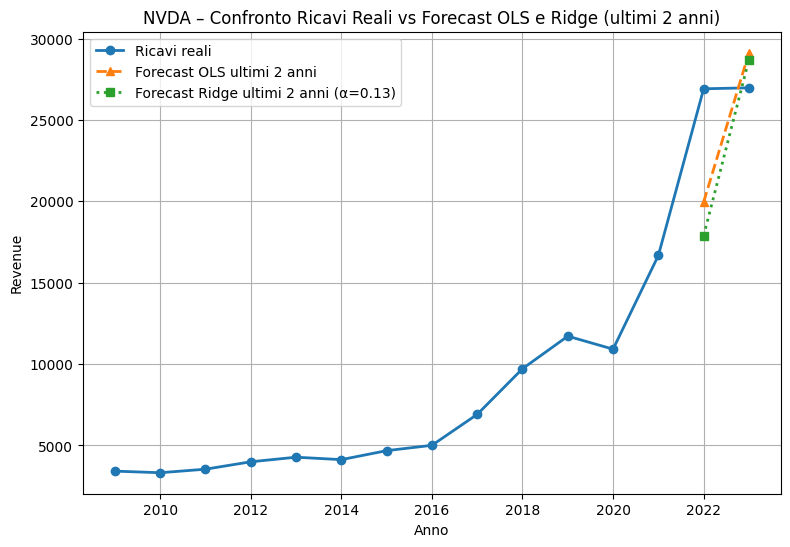

✅ Confronto completato per NVDA
     Year    Reale  Forecast_OLS  Forecast_Ridge
119  2022  26914.0  19959.269178    17883.386452
118  2023  26974.0  29130.256733    28710.341707 



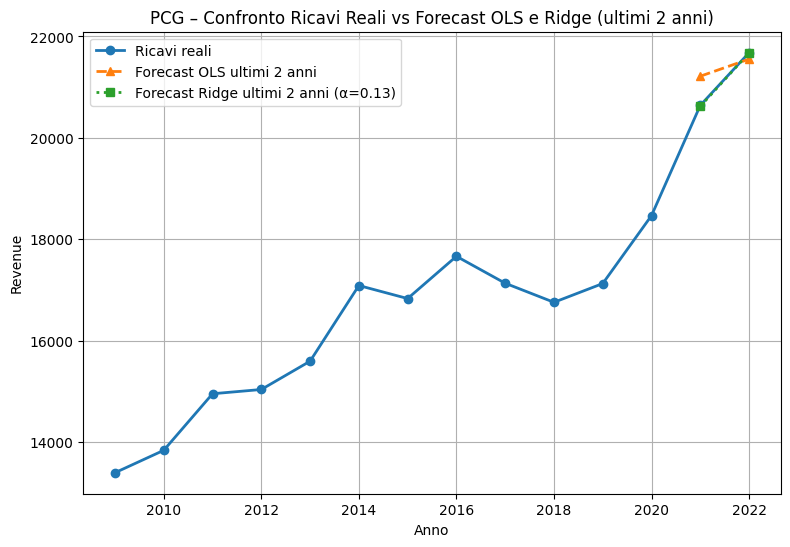

✅ Confronto completato per PCG
    Year    Reale  Forecast_OLS  Forecast_Ridge
67  2021  20642.0  21216.837332    20623.306254
66  2022  21680.0  21553.926997    21676.612503 



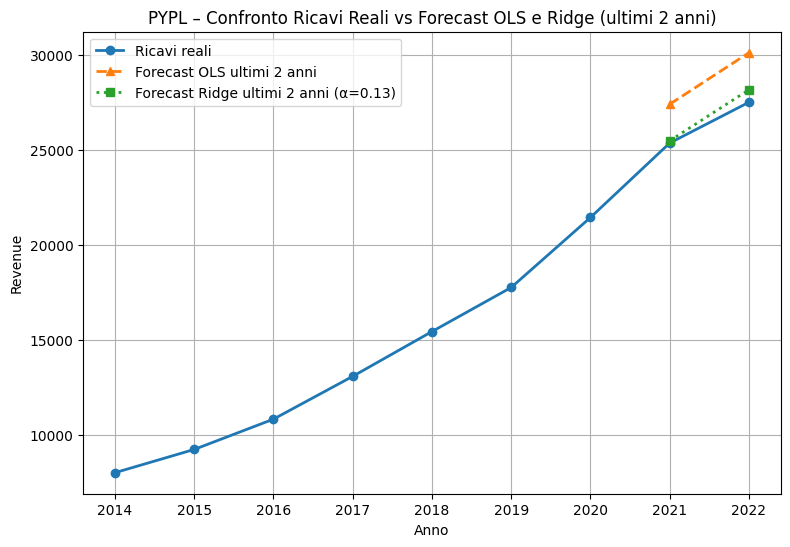

✅ Confronto completato per PYPL
    Year    Reale  Forecast_OLS  Forecast_Ridge
44  2021  25371.0  27412.878049    25490.659662
43  2022  27518.0  30123.991301    28176.274451 

⚠️ SHLDQ ha pochi dati per il confronto.


In [119]:
# --- CONFRONTO RIDGE vs OLS SU ULTIMI 2 ANNI (plot unico) ---
def compare_ridge_vs_ols(company, df_extra, df_raw, alpha=0.13):
    g = df_extra[df_extra["Company"] == company]
    if g["Year"].nunique() < 4:
        print(f"⚠️ {company} ha pochi dati per il confronto.")
        return
    
    cutoff = g["Year"].max() - 2
    df_train = df_extra[~((df_extra["Company"] == company) & (df_extra["Year"] > cutoff))].copy()
    df_test  = df_extra[(df_extra["Company"] == company) & (df_extra["Year"] > cutoff)].copy()
    group_raw = df_raw[df_raw["Company"] == company]

    # OLS
    years_all = sorted(df_extra["Year"].unique())
    df_train["Year"] = pd.Categorical(df_train["Year"], categories=years_all)
    df_test["Year"]  = pd.Categorical(df_test["Year"],  categories=years_all)

    model_ols = smf.ols(formula=formula_forecast + " + C(Year)", data=df_train)\
                   .fit(cov_type="cluster", cov_kwds={"groups": df_train["Company"]})
    preds_ols = np.expm1(model_ols.predict(df_test))

    # Ridge
    model_ridge = smf.ols(formula=formula_forecast, data=df_train)
    res_ridge = model_ridge.fit_regularized(method="elastic_net", alpha=alpha, L1_wt=0)
    preds_ridge = np.expm1(res_ridge.predict(df_test))

    # --- Plot ---
    plt.figure(figsize=(9,6))
    plt.plot(group_raw["Year"], group_raw["Revenue"], marker="o", linewidth=2, label="Ricavi reali")
    plt.plot(df_test["Year"], preds_ols, marker="^", linestyle="--", linewidth=2, label="Forecast OLS ultimi 2 anni")
    plt.plot(df_test["Year"], preds_ridge, marker="s", linestyle=":", linewidth=2, label=f"Forecast Ridge ultimi 2 anni (α={alpha})")
    plt.title(f"{company} – Confronto Ricavi Reali vs Forecast OLS e Ridge (ultimi 2 anni)")
    plt.xlabel("Anno"); plt.ylabel("Revenue"); plt.grid(True); plt.legend()
    plt.show()

    return pd.DataFrame({
        "Year": df_test["Year"].values,
        "Reale": df_test["Revenue"].values,
        "Forecast_OLS": preds_ols,
        "Forecast_Ridge": preds_ridge
    })

# --- LOOP SU TUTTE LE AZIENDE ---
for comp in df_extra["Company"].unique():
    try:
        df_cmp = compare_ridge_vs_ols(comp, df_extra, df_raw, alpha=0.13)
        if df_cmp is not None:
            print(f"✅ Confronto completato per {comp}")
            print(df_cmp, "\n")
    except Exception as e:
        print(f"❌ Problema con {comp}: {e}")

